In [1]:
import json
from utils.gho_filter import filter_gho_users

with open('results.json', 'r') as fp:
    res = json.load(fp)
data = []
for entry in res:
    data += entry['data']['users']

gho_users = set(filter_gho_users(data))

In [85]:
all_borrowers = [d['id'] for d in data if d['borrowHistory']]
len(all_borrowers)

23361

In [4]:
liqs = [d for d in data if d['liquidationCallHistory']]
len(liqs)

1918

In [5]:
len(data)

50946

In [99]:
print(f"% of all v3 users who experienced a liquidation: {1918/23361*100}")

% of all v3 users who experienced a liquidation: 8.210264971533752


In [100]:
no_gho_b = [a for a in all_borrowers if a not in gho_users]
no_gho_liqs = [d for d in data if d['liquidationCallHistory'] and d['id'] not in gho_users]
print(f"Total borrowers (all users excl. GHO users): {len(no_gho_b)}")
print(f"Liquidations (all users excl. GHO users): {len(no_gho_liqs)}")
print(f"Proportion of liquidations for v3 users (excl. GHO users): {len(no_gho_liqs) / len(no_gho_b) * 100}")

Total borrowers (all users excl. GHO users): 21064
Liquidations (all users excl. GHO users): 1682
Proportion of liquidations for v3 users (excl. GHO users): 7.9851879984808205


In [102]:
gho_liqs = [d for d in data if d['id'] in gho_users and d['liquidationCallHistory']]
len(gho_liqs)

236

In [103]:
print(f"% of GHO users who experienced liquidations: {len(gho_liqs) / len(gho_users) * 100}")

% of GHO users who experienced liquidations: 10.274270787984326


In [11]:
import pickle
with open('gho_new_users.pkl', 'rb') as fp:
    gho_new_users = pickle.load(fp)

In [104]:
new_gho_liqs = [d for d in data if d['id'] in gho_new_users and d['liquidationCallHistory']]
len(new_gho_liqs)

69

In [106]:
print(f"% of new GHO users who experienced liquidations: {len(new_gho_liqs) / len(gho_new_users) * 100}")

% of new GHO users who experienced liquidations: 6.117021276595745


In [14]:
old_gho_liqs = [d for d in data if (d['id'] in gho_users and d['id'] not in gho_new_users) and d['liquidationCallHistory']]
len(old_gho_liqs)

167

In [107]:
len(old_gho_liqs) / len(set(gho_users) - set(gho_new_users)) * 100

14.285714285714285

In [20]:
def get_tots_gho_borrows(history):
    gho_borrows = [float(h['amount']) * 1e-18 for h in history if h['reserve']['symbol'] == 'GHO']
    return sum(gho_borrows)

In [21]:
get_tots_gho_borrows(new_gho_liqs[0]['borrowHistory'])

3000.0

# Significant users only
Maybe the high liquidation rate comes from users who are testing out the liq engine with small sums. Let's remove the shrimps and re-run the numbers.

In [25]:
r_gho_liqs = [d for d in data if d['liquidationCallHistory'] and d['id'] in gho_users and get_tots_gho_borrows(d['borrowHistory']) > 1000]
len(r_gho_liqs)

192

In [27]:
fishes = [d for d in data if d['id'] in gho_users and get_tots_gho_borrows(d['borrowHistory']) > 1000]

In [28]:
len(r_gho_liqs) / len(fishes) * 100

11.28084606345476

Barely any changes here

In [32]:
list(gho_users)[:10]

['0x8e93af4057d86d24440efdb35f063104bfa7ca81',
 '0x6802774c25e24c62a2f486c8e38e15bb51c36865',
 '0x573aaafce41839cef3e6d5b9ad727db44bce8ba9',
 '0x25e2ec4c168f2abca2c705daa854ddc6873d1364',
 '0x72c2c890625f7e2ec82a49a5b0d6438c36fc1bb5',
 '0xb9cd7a83f32e7304cedea3910f8ea9d2fa0949bc',
 '0xcf63e1c31805254b6fb3ed7829206c2b2505e3a7',
 '0xd450a1683b0b982ee8e5bc4c93d12b705f1826ae',
 '0xa39ad1a36c6d27391f381d76bd531b924580f98f',
 '0x33aa8ef169fedfbdd3aaa28b131f3795c49197b0']

# GHO Loans only

In [109]:
def is_gho_liq(history):
    return any([entry for entry in history if entry['principalReserve']['symbol'] == "GHO"])

gho_liqs = [d for d in data if is_gho_liq(d['liquidationCallHistory'])]
len(gho_liqs)

152

In [110]:
len(gho_liqs) / len(gho_users) * 100

6.617326948193296

# {Token} loans only

In [137]:
tokens_of_interest = ["USDC", "USDT", "WETH", "wstETH", "DAI", "WBTC", "GHO", "LUSD", "PYUSD", "crvUSD", "LINK", "CRV"]
def is_token_liq(token, history):
    return any([entry for entry in history if entry['principalReserve']['symbol'] == token])
def is_token_action(token, history):
    return any([entry for entry in history if entry['reserve']['symbol'] == token])


res = {}

for token in tokens_of_interest:
    token_liqs = [d for d in data if is_token_liq(token, d['liquidationCallHistory'])]
    token_borrows = [d for d in data if is_token_action(token, d['borrowHistory'])]
    res[token] = {'Total loans': len(token_borrows),
                  'Total liqs': len(token_liqs),
                  'Total liqs %:': len(token_liqs) / len(token_borrows) * 100}

res

{'USDC': {'Total loans': 10076,
  'Total liqs': 822,
  'Total liqs %:': 8.157999206034141},
 'USDT': {'Total loans': 9362,
  'Total liqs': 834,
  'Total liqs %:': 8.90835291604358},
 'WETH': {'Total loans': 4877,
  'Total liqs': 97,
  'Total liqs %:': 1.9889276194381793},
 'wstETH': {'Total loans': 1004,
  'Total liqs': 16,
  'Total liqs %:': 1.593625498007968},
 'DAI': {'Total loans': 2573,
  'Total liqs': 167,
  'Total liqs %:': 6.490478041197047},
 'WBTC': {'Total loans': 1368,
  'Total liqs': 49,
  'Total liqs %:': 3.5818713450292394},
 'GHO': {'Total loans': 2297,
  'Total liqs': 152,
  'Total liqs %:': 6.617326948193296},
 'LUSD': {'Total loans': 418,
  'Total liqs': 14,
  'Total liqs %:': 3.349282296650718},
 'PYUSD': {'Total loans': 310, 'Total liqs': 31, 'Total liqs %:': 10.0},
 'crvUSD': {'Total loans': 146,
  'Total liqs': 4,
  'Total liqs %:': 2.73972602739726},
 'LINK': {'Total loans': 513,
  'Total liqs': 19,
  'Total liqs %:': 3.7037037037037033},
 'CRV': {'Total loans':

In [133]:
token

'AAVE'

# Health

In [56]:
from web3 import Web3
all_users = [Web3.to_checksum_address(u['id']) for u in arbdata]

In [54]:
len(list(set(all_users)))

50946

In [61]:
import pandas as pd
from web3mc import Multicall
from tqdm import tqdm
import os


provider_url = os.getenv('WEB3_PROVIDER_URL')
provider = "https://lb.drpc.org/ogrpc?network=arbitrum&dkey=AskGI4lH8UlFtIRsb5UfRvWWH8poTvgR7pWWdk2eQLM2"
w3 = Web3(Web3.HTTPProvider(provider_url))
multicall = Multicall(provider_url=w3.provider.endpoint_uri, max_retries=3)


contract_address = Web3.to_checksum_address("0x794a61358D6845594F94dc1DB02A252b5b4814aD")
abi = [
    {
        "inputs": [{"internalType": "address", "name": "user", "type": "address"}],
        "name": "getUserAccountData",
        "outputs": [
            {"internalType": "uint256", "name": "totalCollateralBase", "type": "uint256"},
            {"internalType": "uint256", "name": "totalDebtBase", "type": "uint256"},
            {"internalType": "uint256", "name": "availableBorrowsBase", "type": "uint256"},
            {"internalType": "uint256", "name": "currentLiquidationThreshold", "type": "uint256"},
            {"internalType": "uint256", "name": "ltv", "type": "uint256"},
            {"internalType": "uint256", "name": "healthFactor", "type": "uint256"}
        ],
        "stateMutability": "view",
        "type": "function"decoded_results
    }
]

contract = w3.eth.contract(address=contract_address, abi=abi)


async def process_batch(batch):
    calls = [
        contract.functions.getUserAccountData(address)
        for address in batch
    ]
    
    results = await multicall.async_aggregate(calls)
    
    return [
        {
            'address': address,
            'totalCollateralBase': result[0],
            'totalDebtBase': result[1],
            'availableBorrowsBase': result[2],
            'currentLiquidationThreshold': result[3],
            'ltv': result[4],
            'healthFactor': result[5]
        }
        for address, result in zip(batch, results)
    ]


batch_size = 10000
all_results = []

for i in tqdm(range(0, len(all_users), batch_size), desc="Processing batches"):
    batch = all_users[i:i+batch_size]
    batch_results = await process_batch(batch)
    all_results.extend(batch_results)


health_df = pd.DataFrame(all_results)


Processing batches:   0%|                                                                      | 0/6 [00:00<?, ?it/s]/home/ben/.pyenv/versions/3.10.13/lib/python3.10/threading.py:258: RuntimeWarning: coroutine 'Multicall._aggregate' was never awaited
  self._waiters = _deque()
/home/ben/.pyenv/versions/3.10.13/lib/python3.10/threading.py:258: RuntimeWarning: coroutine 'Multicall.async_aggregate' was never awaited
  self._waiters = _deque()
Processing batches: 100%|██████████████████████████████████████████████████████████████| 6/6 [01:23<00:00, 13.86s/it]


In [79]:
health_df['healthFactor'] = health_df['healthFactor'].astype(float)
health_df = health_df[(health_df['totalDebtBase'] > 0) & (health_df['currentLiquidationThreshold'] > 0) & (health_df['ltv'] > 0) & (health_df['availableBorrowsBase'] > 0)]

In [93]:
health_df.describe()

,totalCollateralBase,totalDebtBase,availableBorrowsBase,currentLiquidationThreshold,ltv,healthFactor
count,1.231900e+04,1.231900e+04,1.231900e+04,12319.000000,12319.000000,1.231900e+04
mean,7.614886e+13,4.148302e+13,1.988250e+13,8031.367400,7636.241659,1.441829e+23
std,6.882340e+14,4.347336e+14,2.135295e+14,525.384828,754.128254,5.362206e+24
min,1.340000e+02,1.000000e+00,9.000000e+00,4100.000000,3500.000000,1.021570e+18
25%,1.726644e+11,6.029434e+10,3.772966e+10,7800.000000,7347.000000,1.394607e+18
50%,2.368866e+12,9.505238e+11,5.782885e+11,8100.000000,7850.000000,1.770529e+18
75%,1.500034e+13,6.141761e+12,4.081280e+12,8300.000000,8050.000000,2.553025e+18
max,3.934341e+16,2.694284e+16,1.778791e+16,9500.000000,9300.000000,4.343474e+26


In [80]:
health_df[(health_df['address'].str.lower().isin(gho_users))].describe()

,totalCollateralBase,totalDebtBase,availableBorrowsBase,currentLiquidationThreshold,ltv,healthFactor
count,1.458000e+03,1.458000e+03,1.458000e+03,1458.000000,1458.000000,1.458000e+03
mean,4.502254e+13,2.088320e+13,1.336709e+13,7984.478738,7604.423868,8.963630e+22
std,2.538391e+14,1.242710e+14,8.738881e+13,331.253566,527.634858,1.893775e+24
min,2.500000e+02,1.500000e+01,1.030000e+02,5900.000000,5300.000000,1.024170e+18
25%,3.798204e+10,1.078036e+10,1.118657e+10,7800.000000,7416.000000,1.380528e+18
50%,2.847678e+12,1.054136e+12,6.936075e+11,8057.000000,7750.500000,1.797719e+18
75%,1.674289e+13,6.641788e+12,4.234281e+12,8300.000000,8050.000000,2.736735e+18
max,4.150671e+15,1.886551e+15,1.730597e+15,9500.000000,9300.000000,6.454989e+25


<Axes: >

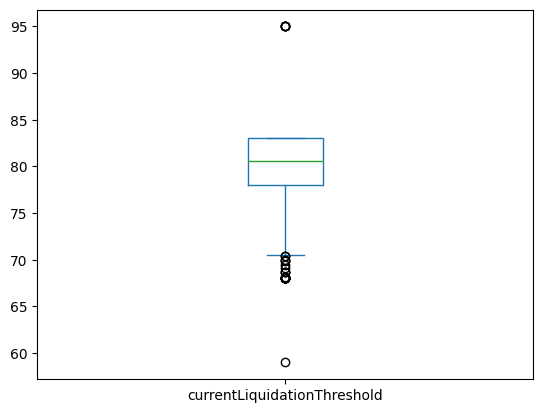

In [81]:
(health_df[(health_df['address'].str.lower().isin(gho_users))]['currentLiquidationThreshold'] / 100).plot.box()

89636.30314059088
1.7977187083495434


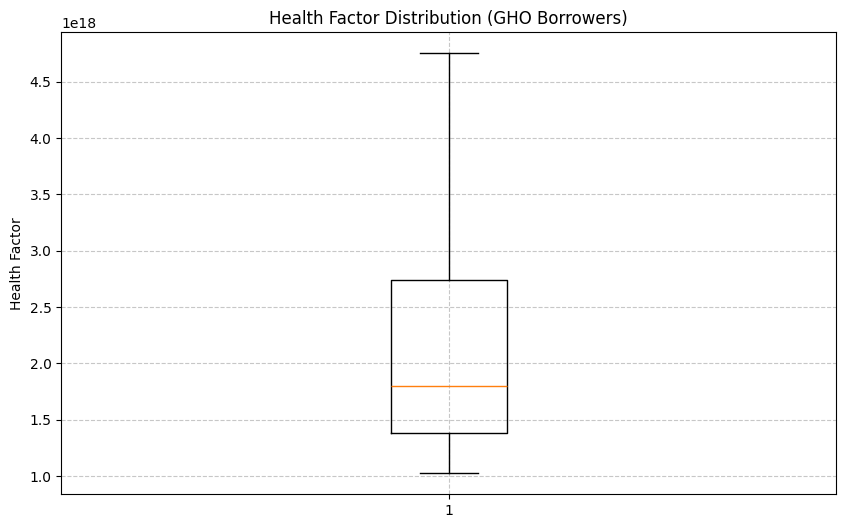

In [111]:
import matplotlib.pyplot as plt
print((health_df[(health_df['address'].str.lower().isin(gho_users))]['healthFactor']).mean() / 1e18)
print((health_df[(health_df['address'].str.lower().isin(gho_users))]['healthFactor']).median() / 1e18)
plt.figure(figsize=(10, 6))
plt.boxplot((health_df[(health_df['address'].str.lower().isin(gho_users))]['healthFactor']), showfliers=False)
plt.title('Health Factor Distribution (GHO Borrowers)')
plt.ylabel('Health Factor')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

151505.28635427434
1.7685422623026803


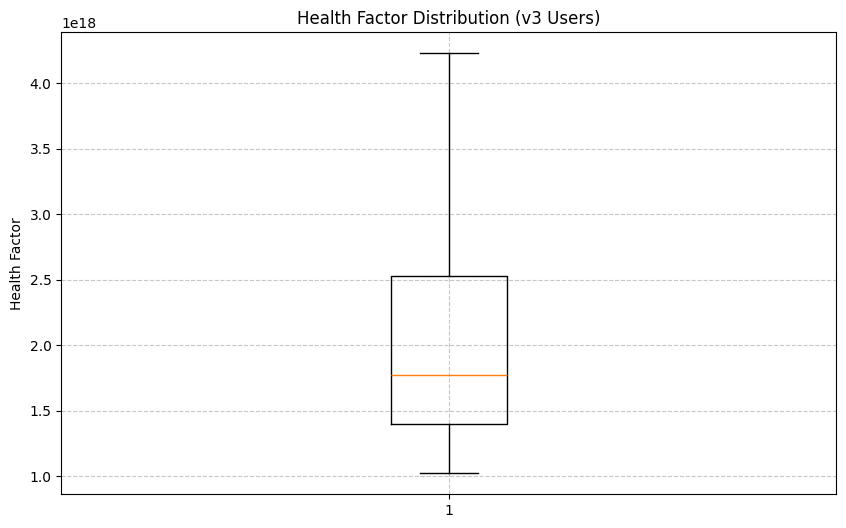

In [97]:

print((health_df[~(health_df['address'].str.lower().isin(gho_users))]['healthFactor']).mean() / 1e18)
print((health_df[~(health_df['address'].str.lower().isin(gho_users))]['healthFactor']).median() / 1e18)
plt.figure(figsize=(10, 6))
plt.boxplot((health_df[~(health_df['address'].str.lower().isin(gho_users))]['healthFactor']), showfliers=False)
plt.title('Health Factor Distribution (v3 Users)')
plt.ylabel('Health Factor')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [88]:
health_df[(health_df['address'].str.lower().isin(gho_users)) & (health_df['ltv'] < 6000)]

,address,totalCollateralBase,totalDebtBase,availableBorrowsBase,currentLiquidationThreshold,ltv,healthFactor
1450,0x071f78421AC4C71604955320f0745a084Db75e1E,560231453820,203973261452,92949409073,6800,5300,1.867683e+18
3557,0x121E1573B7C6c15Aa4C036d54BFd2974Cf38a163,3596380302,1798205868,275467014,7054,5766,1.410788e+18
10472,0x351Da630c4918ad2DCDd8E6408641e14e22Aa6db,7256949,3414276,431907,6800,5300,1.445321e+18
10824,0x36cc7B13029B5DEe4034745FB4F24034f3F2ffc6,327501451433209,100539993463737,86135833853192,5900,5700,1.921881e+18
13411,0x4394Ff9Bb4aDE7305fCd51709721784C592Bf780,5139738277971,773654294196,2083012240700,6940,5558,4.610558e+18
14806,0x4A7998DF2Cd16815271bb6b7d3aE7EB30f50a73a,898393408,346529350,129619156,6800,5300,1.762932e+18
14973,0x4b58D8264be1f0Ed2A9f1eA15f32C7dfb0e8b453,306593674633,85962729476,97472266057,7062,5983,2.518725e+18
15790,0x4F6b0D5621A6353E5685FE81519876C9f6DD025a,4051767186,17550755,2129885854,6800,5300,1.569848e+20
16745,0x543A5ec6989963Ea6D146eCA6b7eEaBAa5cff94A,14545644142912,5892614014395,2011489012863,6873,5434,1.696568e+18
17633,0x58B28E3c88E4A138B3F2506A700AA192E2087dd6,768427673788,257913488893,200299932987,7055,5963,2.101967e+18


In [114]:
def get_borrowed(history):
    return set([entry['reserve']['symbol'] for entry in history])
    
total_borrows = {}
for user in data:
    total_borrows[user['id']] = get_borrowed(user['borrowHistory'])

In [142]:
tokens_of_interest = ["USDC", "USDT", "WETH", "WBTC", "GHO", "LUSD", "LINK", "CRV"]
token_borrowers = {token: set() for token in tokens_of_interest}
for borrowed_token in tokens_of_interest:
    for user, borrowed_tokens in total_borrows.items():
        if borrowed_token in borrowed_tokens:
            token_borrowers[borrowed_token].add(user)

USDC
201204.21548906193
1.8020929887850738


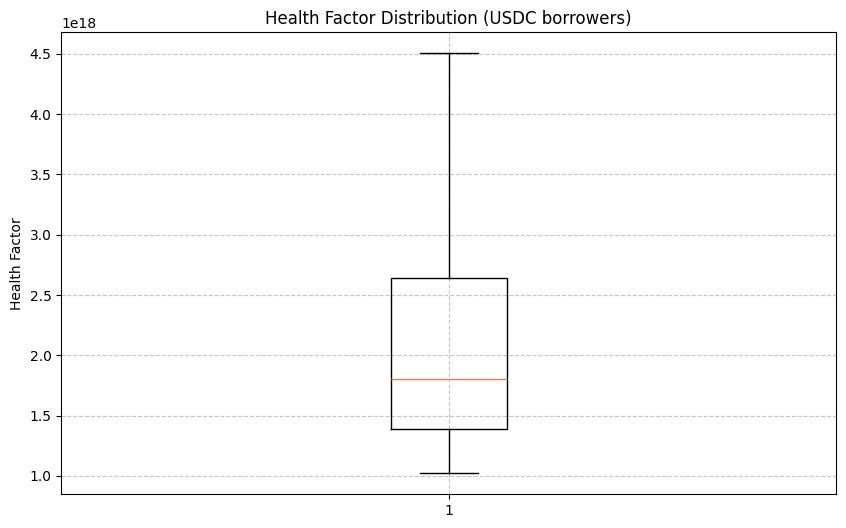

USDT
254364.8599403287
1.824504250475989


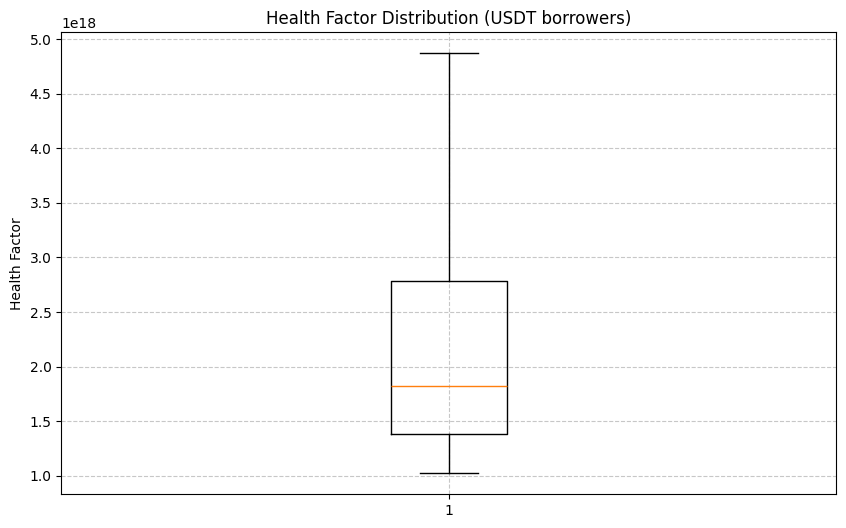

WETH
95597.4869418302
1.8190082108189394


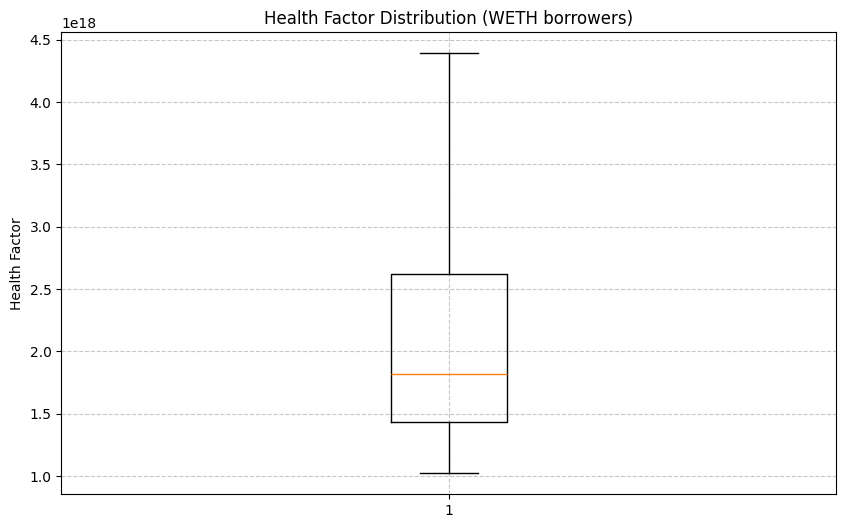

wstETH


KeyError: 'wstETH'

In [139]:

for token in tokens_of_interest:
    
    print(token)
    print((health_df[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['healthFactor']).mean() / 1e18)
    print((health_df[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['healthFactor']).median() / 1e18)
    plt.figure(figsize=(10, 6))
    plt.boxplot((health_df[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['healthFactor']), showfliers=False)
    plt.title(f'Health Factor Distribution ({token} borrowers)')
    plt.ylabel('Health Factor')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

USDC
80.7353898505696
81.3


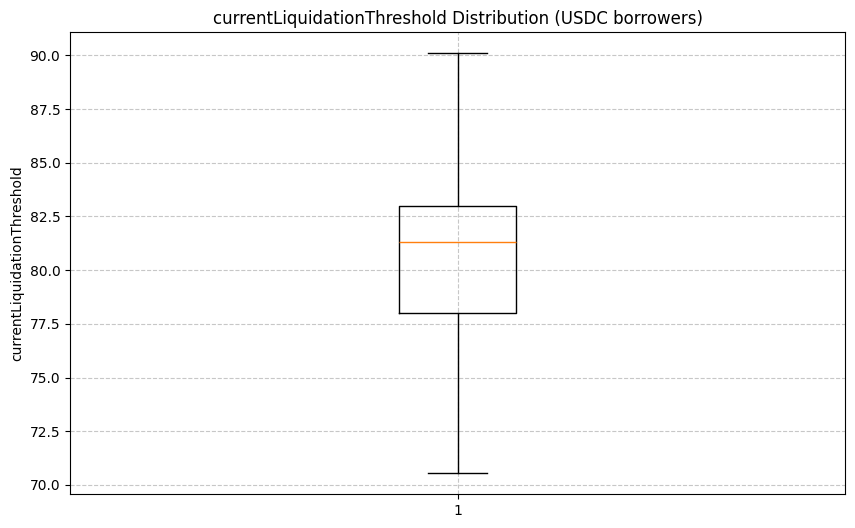

USDT
80.86395345345345
81.17


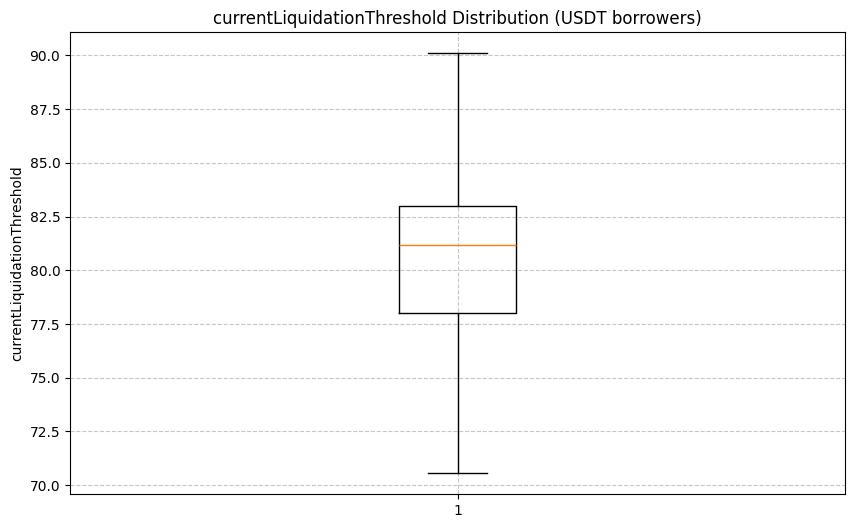

WETH
79.86739121912974
81.0


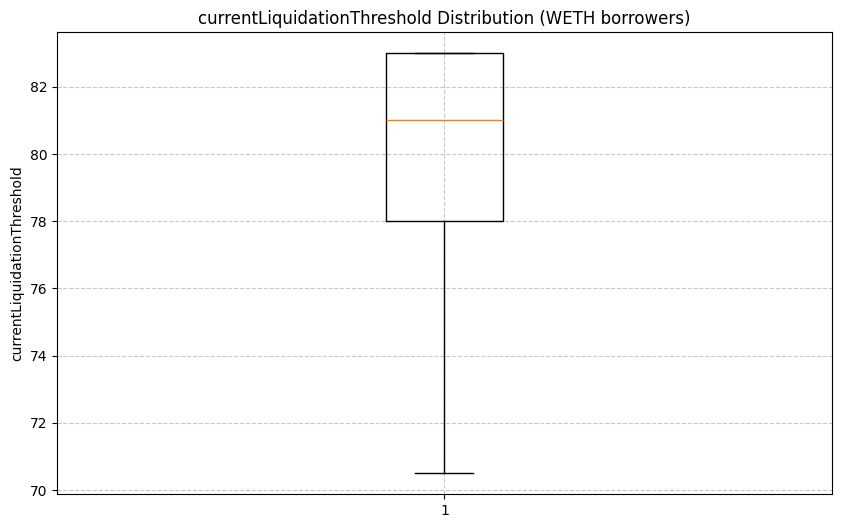

WBTC
80.34303170522708
81.0


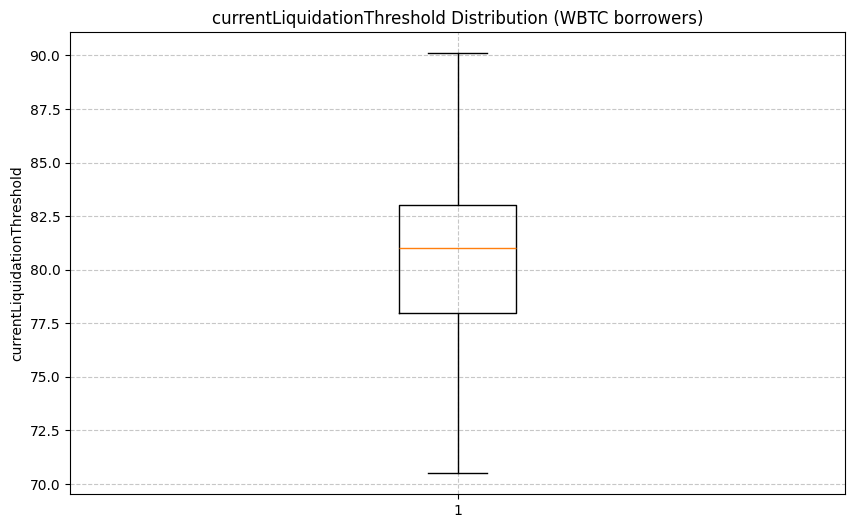

GHO
80.37661817512199
81.0


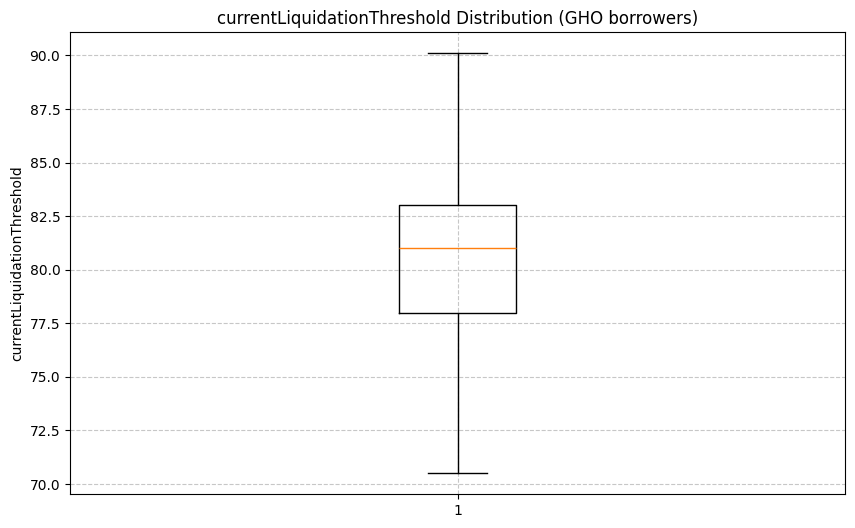

LUSD
80.33258179114343
81.0


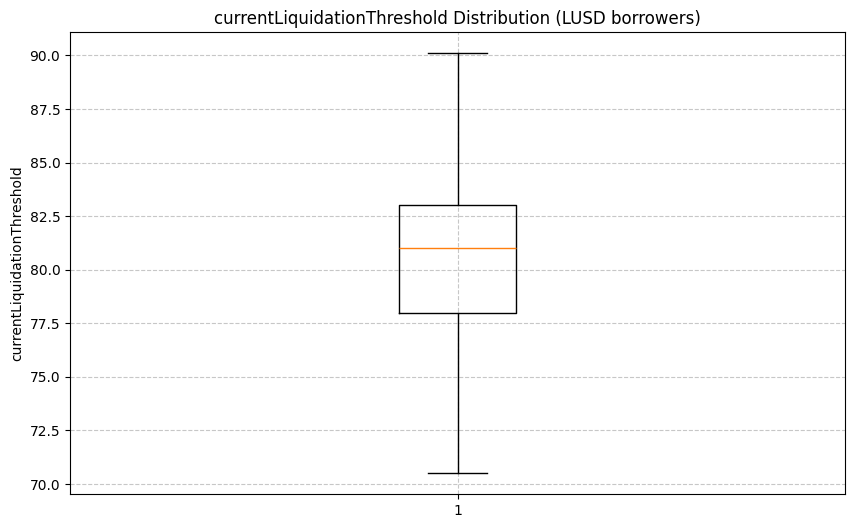

LINK
80.36545371447565
81.0


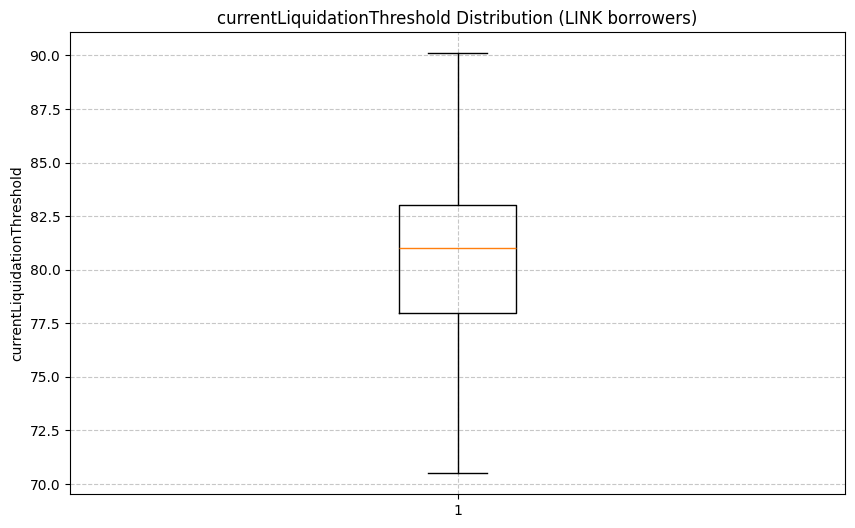

CRV
80.31712207877105
81.0


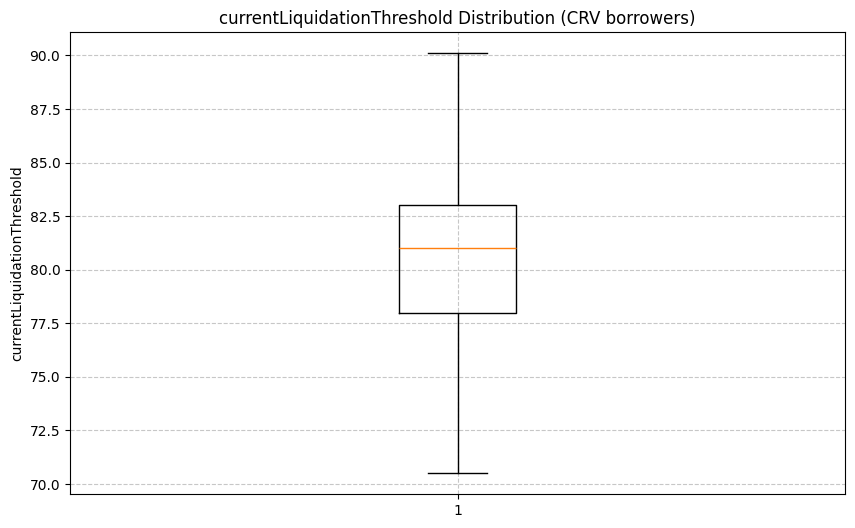

In [123]:

for token in tokens_of_interest:
    
    print(token)
    print((health_df[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['currentLiquidationThreshold']).mean() / 100)
    print((health_df[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['currentLiquidationThreshold']).median() / 100)
    plt.figure(figsize=(10, 6))
    plt.boxplot((health_df[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['currentLiquidationThreshold']) / 100, showfliers=False)
    plt.title(f'currentLiquidationThreshold Distribution ({token} borrowers)')
    plt.ylabel('currentLiquidationThreshold')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

In [144]:
import numpy as np
import json

violin_data = {}

for token in tokens_of_interest:
    health_factors = health_df[~(health_df['address'].str.lower().isin(token_borrowers[token]))]['healthFactor'] / 1e18
    
    q1 = health_factors.quantile(0.25)
    q3 = health_factors.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    filtered_health_factors = health_factors[(health_factors >= lower_bound) & (health_factors <= upper_bound)]
    
    rounded_health_factors = np.round(filtered_health_factors, 3).tolist()
    
    violin_data[token] = rounded_health_factors

with open('health_violin_data.json', 'w') as f:
    json.dump(violin_data, f)